# Thematic differences (Slovenia)

DHH23 Parliament group

Author: Pontus H.

In [182]:
# Set the theme here
THEME = 'healthcare_SI'
# Set the output path for the CSV:s and keyword figure
OUTPUT_PATH = '../thematic_differences/'

In [183]:
from cuml.manifold import UMAP
from cuml.cluster.hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

import pandas as pd

In [184]:
# Optional stopwords
with open('../data/stopwords-si.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

Set up the BERTopic pipeline

In [185]:
# Parameters
HDBSCAN_MIN_CLUSTER_SIZE = 50
HDBSCAN_MIN_SAMPLES = 1
HDBSCAN_CLUSTER_SELECTION_EPSILON = 0

# Step 1 - Extract embeddings
# embedding_model = SentenceTransformer('all-MiniLM-L6-v2') # English
embedding_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2') # Other languages

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples=HDBSCAN_MIN_SAMPLES,
    cluster_selection_epsilon=HDBSCAN_CLUSTER_SELECTION_EPSILON,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,)

# Step 3 - Cluster reduced embeddings with KMeans
# hdbscan_model = KMeans(n_clusters=100, random_state=42)

# Step 4 - Tokenize topics
# vectorizer_model = CountVectorizer(stop_words="english") # English
vectorizer_model = CountVectorizer(stop_words=stopwords) # Other languages

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
# representation_model = KeyBERTInspired()
representation_model = MaximalMarginalRelevance(diversity=0.8)

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  #nr_topics="25",
  calculate_probabilities=True,
  n_gram_range=(1, 3)
)

In [186]:
df = pd.read_csv(f'../data/{THEME}.csv')
df.head()

,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,Subcorpus,...,Speaker_party,Speaker_party_name,Party_status,Speaker_name,Speaker_gender,Speaker_birth,speech,speech_split,sentiment,speech_length
0,ParlaMint-SI_2017-07-10-SDZ7-Redna-32.u28,Minutes of the National Assembly of the Republ...,2017-07-10,Lower house,7,NaN,32,NaN,NaN,Reference,...,SDS,Slovenska demokratska stranka,Opposition,"Godec, Jelka",F,1969,Najlepša hvala za besedo. Spoštovani predsedni...,"Spoštovani predsednik Vlade, tako kot branite...",-0.746094,2519
1,ParlaMint-SI_2017-07-10-SDZ7-Redna-32.u30,Minutes of the National Assembly of the Republ...,2017-07-10,Lower house,7,NaN,32,NaN,NaN,Reference,...,SMC,Stranka modernega centra,Coalition,"Cerar, Miro",M,1963,"Hvala lepa. Vsi vemo, spoštovana poslanka Gode...","Vsi vemo, spoštovana poslanka Godec, da je va...",0.251953,4370
2,ParlaMint-SI_2017-07-10-SDZ7-Redna-32.u32,Minutes of the National Assembly of the Republ...,2017-07-10,Lower house,7,NaN,32,NaN,NaN,Reference,...,SDS,Slovenska demokratska stranka,Opposition,"Godec, Jelka",F,1969,"Spoštovani predsednik Vlade, jaz ne vem, kdo v...","Vse, kar ste zdajle povedali, je v bistvu tra...",-0.967773,1977
3,ParlaMint-SI_2017-07-10-SDZ7-Redna-32.u36,Minutes of the National Assembly of the Republ...,2017-07-10,Lower house,7,NaN,32,NaN,NaN,Reference,...,SMC,Stranka modernega centra,Coalition,"Cerar, Miro",M,1963,"Mislim, da bo ona odgovorila na vsa ta vaša vp...",Bi pa nekaj povedal. Naša država se je pred l...,-1.000000,1902
4,ParlaMint-SI_2017-07-10-SDZ7-Redna-32.u38,Minutes of the National Assembly of the Republ...,2017-07-10,Lower house,7,NaN,32,NaN,NaN,Reference,...,SDS,Slovenska demokratska stranka,Opposition,"Godec, Jelka",F,1969,"Glede na to, da je predsednik Vlade pravkar de...","Predsednik Vlade, jaz pa vam lahko zdaj zelo ...",-0.625488,2165


In [187]:
df['Speaker_party'].describe()

count     13789
unique       24
top         SDS
freq       3232
Name: Speaker_party, dtype: object

In [188]:
# Reference running time for this cell: 4min 00s
topics, probs = topic_model.fit_transform(df['speech'])


In [189]:
# Reduce outliers
new_topics = topic_model.reduce_outliers(df['speech'], topics, strategy="c-tf-idf", threshold=0.1)

In [190]:
pd.Series(new_topics).value_counts()

 0     4311
 1     2172
 2      697
 3      595
 5      577
 7      518
 10     498
 4      493
 6      487
 9      338
 8      322
-1      287
 11     214
 14     208
 13     197
 12     170
 15     169
 29     157
 16     154
 28     141
 26     134
 27     125
 19     123
 18     111
 21     110
 23      99
 20      97
 25      95
 24      93
 22      91
 17      86
dtype: int64

In [191]:
#topic_model.save(f"../data/topic_model_epsilon{HDBSCAN_CLUSTER_SELECTION_EPSILON}_clustersize{HDBSCAN_MIN_CLUSTER_SIZE}.bin")

In [192]:
#topic_model = BERTopic.load("../data/topic_model_epsilon0_clustersize50.bin")

In [193]:
# Number of topics
print(f"Number of topics before: {len(pd.Series(topics).unique())}")
print(f"Number of topics before: {len(pd.Series(new_topics).unique())}")

Number of topics before: 31
Number of topics before: 31


In [194]:
# The count of speeches per topic. -1 is the noise(outlier) topic
pd.Series(topic_model.hdbscan_model.labels_).value_counts()

-1     4888
 8     3438
 18    1209
 7      562
 6      390
 22     379
 25     337
 23     328
 28     246
 16     208
 9      188
 26     182
 0      145
 11     130
 5      112
 24     109
 21     108
 12      91
 19      78
 1       77
 15      77
 14      69
 10      68
 13      64
 3       58
 2       57
 27      56
 29      56
 20      56
 17      52
 4       51
dtype: int64

In [195]:
topic_model.visualize_topics()

Topics over time

In [196]:
# Reference running time for this cell: 2min 30s
topics_over_time = topic_model.topics_over_time(df['speech'], df['Date'].to_list(), nr_bins=20)

In [197]:
# Save the topics_over_time dataframe to a feather file
#topics_over_time.to_feather("../data/topics_over_time.feather")

In [198]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)
#topic_model.visualize_topics_over_time(topics_over_time, topics=[0,18])


What is interesting about the plot above is that the keywords associated with the topic CHANGE over time! Maybe this could be a useful pointer towards further exploration.

In [199]:
# Brexit
topics_over_time[topics_over_time['Topic'] == 0]

,Topic,Words,Frequency,Timestamp,Name
1,0,"zdravstvenega, vprašanje, zakona, seveda, tem",88,2000-11-22 04:52:19.200,0_zdravil_hvala_zdravstva_storitev
27,0,"hvala, zdravstvenega, jezika, zakona, minister",146,2001-12-24 20:24:00.000,0_zdravil_hvala_zdravstva_storitev
52,0,"zakona, zdravstvenega, ministrstvo, ta, predlog",109,2003-01-18 16:48:00.000,0_zdravil_hvala_zdravstva_storitev
77,0,"minister, kebra, hvala, zavarovanja, zdravstva",95,2004-02-12 13:12:00.000,0_zdravil_hvala_zdravstva_storitev
105,0,"zakona, zavarovanja, vzajemne, zdravstvenega, ...",247,2005-03-08 09:36:00.000,0_zdravil_hvala_zdravstva_storitev
134,0,"minister, zdravstvenega, gospod, koncesije, miz",206,2006-04-02 06:00:00.000,0_zdravil_hvala_zdravstva_storitev
161,0,"zdravil, storitev, zdravstvenega, lepa, tem",259,2007-04-27 02:24:00.000,0_zdravil_hvala_zdravstva_storitev
190,0,"zdravstvenega, storitev, hvala, tem, vzajemna",130,2008-05-20 22:48:00.000,0_zdravil_hvala_zdravstva_storitev
211,0,"marušič, zdravstva, hvala, bo, storitev",87,2009-06-14 19:12:00.000,0_zdravil_hvala_zdravstva_storitev
239,0,"razlage, zakonodajno, hvala, minister, polnega",105,2010-07-09 15:36:00.000,0_zdravil_hvala_zdravstva_storitev


In [200]:
topic_word_scores = topic_model.visualize_barchart(width=330, height=330, top_n_topics=10, n_words=10)
topic_word_scores.write_image(f"{OUTPUT_PATH}{THEME}_topic_keywords.png")
topic_word_scores

# Word Clouds

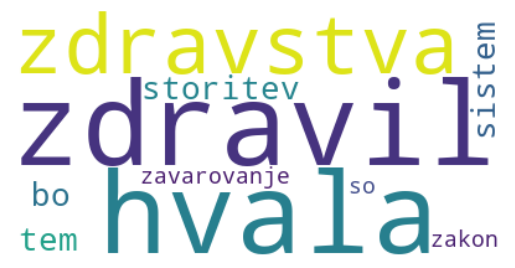

In [201]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=0)

In [202]:
topic_model.visualize_heatmap(n_clusters=5, top_n_topics=10)

For the top 10 topics, get the percentage of Labour speeches and Conservative speeches. Include the keywords related to the topic.

In [203]:
def get_keywords(topic):
    return [word for word, _ in topic_model.get_topic(topic)]
get_keywords(0)

['zdravil',
 'hvala',
 'zdravstva',
 'storitev',
 'sistem',
 'bo',
 'tem',
 'zavarovanje',
 'zakon',
 'so']

In [204]:
speech_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party']})
# Remove the noise topic
speech_topic_party = speech_topic_party[speech_topic_party['topic'] != -1]
# Remove topics > 10
speech_topic_party = speech_topic_party[speech_topic_party['topic'] < 10]
# Drop speeches with no party
speech_topic_party = speech_topic_party.dropna()
# Set the party name to 'OTHER' if the party name does not contain 'SDS' or 'SD'
speech_topic_party.loc[~speech_topic_party['party'].str.contains('SDS|SD'), 'party'] = 'OTHER'
# Set the party name to 'OTHER' if the party name is 'ZLSD'
speech_topic_party.loc[speech_topic_party['party'] == 'ZLSD', 'party'] = 'OTHER'
# Group by party and topic
speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
speech_topic_party = speech_topic_party.pivot(index='topic', columns='party', values='counts').fillna(0)
speech_topic_party.to_csv(f"{OUTPUT_PATH}{THEME}_speeches_topic_party.csv")
speech_topic_party

party,OTHER,SD,SDS
topic,,,
0,2740,458,1085
1,1274,304,589
2,479,103,112
3,426,66,102
4,299,59,133
5,349,68,153
6,332,54,99
7,347,60,108
8,186,53,83


In [205]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages = speech_topic_party.div(speech_topic_party.sum(axis=0), axis=1)
# Multiply by 100 to get percentages and round to 1 decimal
percentages = (percentages * 100).round(1)
percentages.reset_index()
percentages

party,OTHER,SD,SDS
topic,,,
0,41.3,36.1,42.5
1,19.2,23.9,23.1
2,7.2,8.1,4.4
3,6.4,5.2,4.0
4,4.5,4.6,5.2
5,5.3,5.4,6.0
6,5.0,4.3,3.9
7,5.2,4.7,4.2
8,2.8,4.2,3.2


In [206]:
# Reset the index to get the topic column back and add a new column 'keywords'
percentages = percentages.reset_index()
percentages['keywords'] = percentages['topic'].apply(lambda x: get_keywords(x))
percentages = percentages.set_index('topic')
percentages.to_csv(f'{OUTPUT_PATH}{THEME}_percentages.csv')
percentages

party,OTHER,SD,SDS,keywords
topic,,,,
0,41.3,36.1,42.5,"[zdravil, hvala, zdravstva, storitev, sistem, ..."
1,19.2,23.9,23.1,"[sem, potem, tem, danes, samo, seveda, so, vse..."
2,7.2,8.1,4.4,"[19, epidemijo, cepljenje, vlada, širjenja, 20..."
3,6.4,5.2,4.0,"[šole, potrebami, posebnimi, otroci, družine, ..."
4,4.5,4.6,5.2,"[evropske, unije, tem, bo, države, bomo, vlada..."
5,5.3,5.4,6.0,"[evrov, rast, milijonov, 2007, bo, slovenija, ..."
6,5.0,4.3,3.9,"[bo, sloveniji, stranke, so, gre, tem, ki, sod..."
7,5.2,4.7,4.2,"[milijonov, letu, evrov, rast, rebalans, prora..."
8,2.8,4.2,3.2,"[zapora, referendum, sankcij, sodnikov, državn..."


In [207]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages_per_row = speech_topic_party.div(speech_topic_party.sum(axis=1), axis=0)
# Multiply by 100 to get percentages and round to 1 decimal
percentages_per_row = (percentages_per_row * 100).round(1)
percentages_per_row.to_csv(f'{OUTPUT_PATH}{THEME}_percentages_per_row.csv')
percentages_per_row.reset_index()

party,topic,OTHER,SD,SDS
0,0,64.0,10.7,25.3
1,1,58.8,14.0,27.2
2,2,69.0,14.8,16.1
3,3,71.7,11.1,17.2
4,4,60.9,12.0,27.1
5,5,61.2,11.9,26.8
6,6,68.5,11.1,20.4
7,7,67.4,11.7,21.0
8,8,57.8,16.5,25.8
9,9,59.6,13.5,26.9


Calculate mean sentiment for each topic per party

In [208]:
sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party'], 'sentiment': df['sentiment']})
# Remove the noise topic
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] != -1]
# Remove topics > 10
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] < 10]
# Drop speeches with no party
sentiment_topic_party = sentiment_topic_party.dropna()
# Set the party name to 'OTHER' if the party name does not contain 'SDS' or 'SD'
sentiment_topic_party.loc[~sentiment_topic_party['party'].str.contains('SDS|SD'), 'party'] = 'OTHER'
# Set the party name to 'OTHER' if the party name is 'ZLSD'
sentiment_topic_party.loc[sentiment_topic_party['party'] == 'ZLSD', 'party'] = 'OTHER'
# Group by party and topic and take the average sentiment
sentiment_topic_party = sentiment_topic_party.groupby(['topic', 'party']).mean().reset_index()
# speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
sentiment_topic_party = sentiment_topic_party.pivot(index='topic', columns='party', values='sentiment').fillna(0).round(2)
sentiment_topic_party.to_csv(f'{OUTPUT_PATH}{THEME}_sentiment.csv')
sentiment_topic_party

party,OTHER,SD,SDS
topic,,,
0,-0.35,-0.30,-0.40
1,-0.55,-0.51,-0.58
2,-0.41,-0.55,-0.29
3,-0.10,-0.20,-0.28
4,-0.27,-0.26,-0.38
5,-0.17,-0.19,-0.23
6,-0.21,-0.19,-0.25
7,-0.31,-0.35,-0.45
8,-0.34,-0.19,-0.43
